In [1]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import mannwhitneyu as mwu
sns.set(style="darkgrid")

Please specifiy the location of the CSV file that Pyexec created

In [11]:
data = pd.read_csv("/home/michael/pyexec-output/20200911-113129/stats.csv")
data = data.replace([-1], pd.NA)
print(data.info())
print(data["loc"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 3 non-null      int64  
 1   name                       3 non-null      object 
 2   project_on_pypi            3 non-null      bool   
 3   github_link_found          3 non-null      bool   
 4   github_repo_exists         3 non-null      bool   
 5   github_repo_created_at     3 non-null      object 
 6   github_repo_last_updated   3 non-null      object 
 7   has_requirementstxt        3 non-null      bool   
 8   has_makefile               3 non-null      bool   
 9   has_pipfile                3 non-null      bool   
 10  loc                        2 non-null      float64
 11  average_complexity         2 non-null      float64
 12  min_python_version         2 non-null      float64
 13  dockerfile_found           3 non-null      bool   
 14

# Basic stats
Total number of times a project has reached some stage.
Good to have as a sanity-check.

In [17]:
def pypi() -> DataFrame:
    return data[data["project_on_pypi"]]
def link() -> DataFrame:
    return data[data["github_link_found"]]
def exists() -> DataFrame:
    return data[data["github_repo_exists"]]
def mined() -> DataFrame:
    return data[data["github_repo_exists"]]
def inferred() -> DataFrame:
    return data[data["dockerfile_found"]]
def build(*, complement=False) -> DataFrame:
    return data[data["dockerimage_build_success"] != complement]
def build_and_testsuit() -> DataFrame:
    return build()[build()["testcase_count"] > 0]
def executed(*, complement=False) -> DataFrame:
    return data[data["testsuit_executed"] != complement]
def success(*, complement=False) -> DataFrame:
    return data[data["testsuit_result_parsed"] != complement]

print("Attempted: {}".format(len(data)))
print("Found on PyPI: {}:".format(len(pypi())))
print("GitHub link found: {}".format(len(link())))
print("GitHub link is valid: {}".format(len(exists())))
print("Mined: {}".format(len(mined())))
print("Dockerimage inferred: {}".format(len(inferred())))
print("Dockerimage build success: {}".format(len(build())))
print("Testsuits executed: {}".format(len(executed())))
print("Testcases executed and parsed: {}".format(len(success())))

Attempted: 3
Found on PyPI: 3:
GitHub link found: 3
GitHub link is valid: 2
Mined: 2
Dockerimage inferred: 2
Dockerimage build success: 2
Testsuits executed: 2
Testcases executed and parsed: 2


# RQ1: Fraction of projects for which an environment is inferred
Based on the number of project for which a GitHub link has been found and which cound be cloned.
Only projects for which a dockerfile has been inferred and for which a dockerimage was build successfully are counted here.

In [4]:
print("{}%".format(len(build()) / len(mined()) * 100))

100.0%


# RQ2: Fraction of projects for which the testcases could be executed
Based on the number of projects for which a dockerimage could be build

In [5]:
print("Fraction of projects for which a testsuit was detected: {}%".format(len(build_and_testsuit()) / len(executed()) * 100))
print("Fraction of projects for which a testsuit was executed: {}%".format(len(executed()) / len(build()) * 100))
print("Fraction of projects for which testsuit execution was successful: {}%".format(len(success()) / len(build()) * 100))

Fraction of projects for which a testsuit was detected: 100.0%
Fraction of projects for which a testsuit was executed: 100.0%
Fraction of projects for which testsuit execution was successful: 100.0%


So the fraction of successful testcase executions to all testsuit executions is:

In [6]:
print("\t{}%".format(len(success()) / len(executed()) * 100))

	100.0%


# RQ3 Representativness of project for which a environment has been found

First the distribtutions for lines of code (LOC), average cyclomatic complexity and minmum required Python version for all mined project

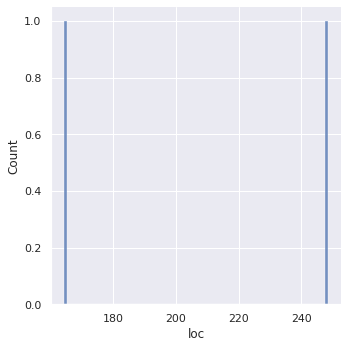

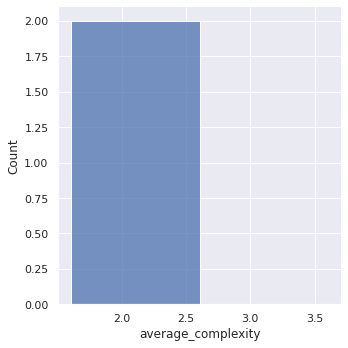

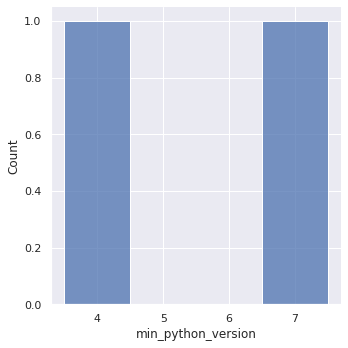

In [7]:
sns.displot(mined(), discrete=True, x="loc")
sns.displot(mined(), discrete=True, x="average_complexity")
sns.displot(mined(), discrete=True, x="min_python_version")


Now the same for all project for which a dockerimage could be build

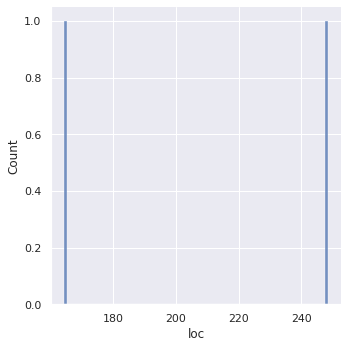

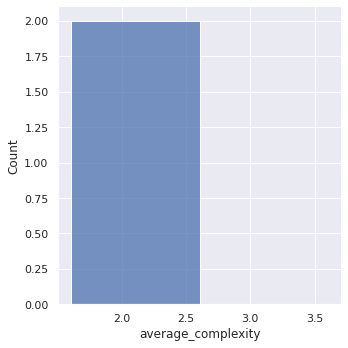

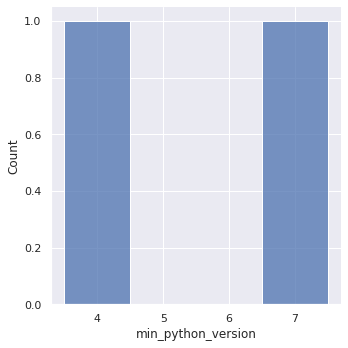

In [8]:
sns.displot(build(), discrete=True, x="loc")
sns.displot(build(), discrete=True, x="average_complexity")
sns.displot(build(), discrete=True, x="min_python_version")

Lets have a look at the resuls of the Mann-Whitney U-Test for these three variables

In [19]:

print("LOC p-value: {}".format(mwu(build(complement=True)["loc"].dropna(), build()["loc"].dropna(), alternative="two-sided")[1]))
print("Complexity p-value: {}".format(mwu(build(complement=True)["average_complexity"].dropna(), build()["average_complexity"].dropna(), alternative="two-sided")[1]))
print("Version p-value: {}".format(mwu(build(complement=True)["min_python_version"].dropna(), build()["min_python_version"].dropna(), alternative="two-sided")[1]))

LOC p-value: 0.0
Complexity p-value: 0.0
Version p-value: 0.0


/home/michael/.local/share/virtualenvs/pyexec-rEz73fpI/lib/python3.8/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/home/michael/.local/share/virtualenvs/pyexec-rEz73fpI/lib/python3.8/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/home/michael/.local/share/virtualenvs/pyexec-rEz73fpI/lib/python3.8/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
